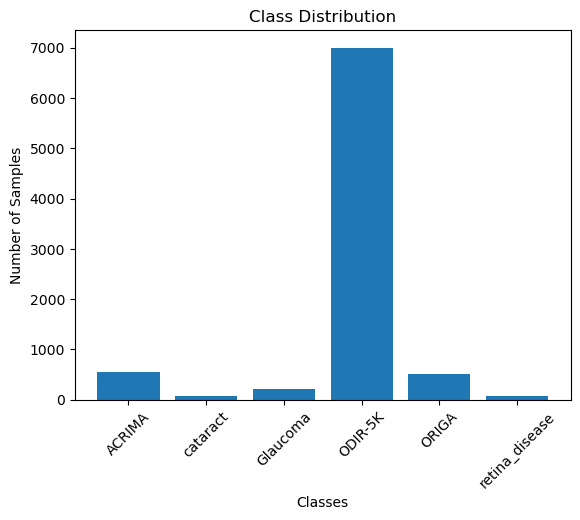

In [ ]:
import os
import matplotlib.pyplot as plt

train_dir = r'C:\Users\wazwa\Downloads\Notebooks - ANN - DNN\Project\DATASET_101\Train'
test_dir = r'C:\Users\wazwa\Downloads\Notebooks - ANN - DNN\Project\DATASET_101\Train'
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

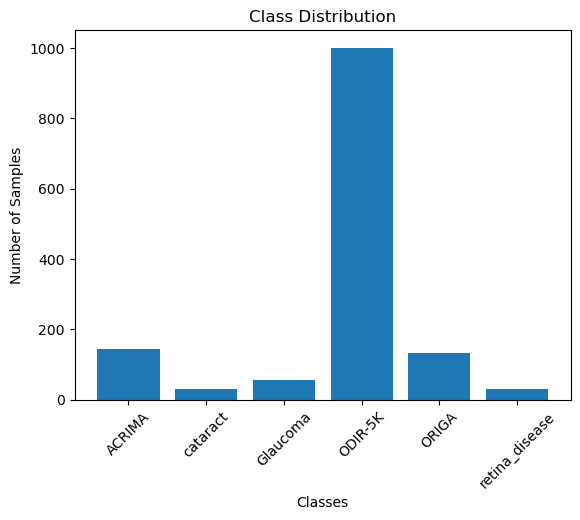

In [ ]:
test_dir = r'C:\Users\wazwa\Downloads\Notebooks - ANN - DNN\Project\DATASET_101\test'
class_counts = {}
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import os
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoModelForImageClassification, AdamW, get_scheduler
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Check if GPU is available, if not, fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can move your class weights to the appropriate device
class_weights = torch.FloatTensor(class_weights).to(device)

# Set up directories
train_dir = r'C:\Users\wazwa\Downloads\Notebooks - ANN - DNN\Project\DATASET_101\Train'
test_dir = r'C:\Users\wazwa\Downloads\Notebooks - ANN - DNN\Project\DATASET_101\Test'

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calculate class weights
class_counts = np.array([len(np.where(np.array(train_dataset.targets) == t)[0]) for t in range(len(train_dataset.classes))])
class_weights = 1.0 / class_counts
class_weights = class_weights / np.sum(class_weights)  # Normalize weights
class_weights = torch.FloatTensor(class_weights).to(device)  # Move weights to the appropriate device

# Load the model
model = AutoModelForImageClassification.from_pretrained(
    "ttangmo24/vit-base-classification-Eye-Diseases",
    num_labels=len(train_dataset.classes),  # Use the number of classes in your dataset
    ignore_mismatched_sizes=True
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Set up the learning rate scheduler
num_epochs = 5  # Set the number of epochs
num_training_steps = num_epochs * len(train_loader)  # Total training steps
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Model checkpointing
best_accuracy = 0.0
model_save_path = "best_model.pth"

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss with class weights
        loss = torch.nn.functional.cross_entropy(outputs.logits, labels, weight=class_weights)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

    # Evaluation on validation set to determine best model
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images, labels = batch
            images = images.to(device)

            outputs = model(images)
            predicted_labels = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            all_predictions.extend(predicted_labels)
            all_labels.extend(labels.numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model saved with accuracy: {best_accuracy:.4f}")

# Print final classification report and confusion matrix
print('Confusion Matrix')
print(confusion_matrix(all_labels, all_predictions))

target_names = train_dataset.classes  # Get class names from the dataset
print('Classification Report')
print(classification_report(all_labels, all_predictions, target_names=target_names, digits=4))


Some weights of ViTForImageClassification were not initialized from the model checkpoint at ttangmo24/vit-base-classification-Eye-Diseases and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 264/264 [1:02:18<00:00, 14.16s/it]


Epoch [1/5], Loss: 0.7172


100%|██████████| 44/44 [04:01<00:00,  5.49s/it]


Validation Accuracy: 0.9584
Best model saved with accuracy: 0.9584


100%|██████████| 264/264 [1:00:42<00:00, 13.80s/it]


Epoch [2/5], Loss: 0.4361


100%|██████████| 44/44 [04:12<00:00,  5.75s/it]


Validation Accuracy: 0.9326


100%|██████████| 264/264 [1:00:33<00:00, 13.76s/it]


Epoch [3/5], Loss: 0.3633


100%|██████████| 44/44 [04:00<00:00,  5.47s/it]


Validation Accuracy: 0.9498


100%|██████████| 264/264 [1:00:24<00:00, 13.73s/it]


Epoch [4/5], Loss: 0.2545


100%|██████████| 44/44 [04:05<00:00,  5.57s/it]


Validation Accuracy: 0.9627
Best model saved with accuracy: 0.9627


100%|██████████| 264/264 [1:05:15<00:00, 14.83s/it]


Epoch [5/5], Loss: 0.2115


100%|██████████| 44/44 [04:57<00:00,  6.76s/it]

Validation Accuracy: 0.9620
Confusion Matrix
[[145   0   0   0   0   0]
 [  0  31   0  21   0   5]
 [  0   1 999   0   0   0]
 [  0  14   0 119   0   0]
 [  0   2   0   0  25   3]
 [  0   4   0   0   3  23]]
Classification Report
                precision    recall  f1-score   support

        ACRIMA     1.0000    1.0000    1.0000       145
      Glaucoma     0.5962    0.5439    0.5688        57
       ODIR-5K     1.0000    0.9990    0.9995      1000
         ORIGA     0.8500    0.8947    0.8718       133
      cataract     0.8929    0.8333    0.8621        30
retina_disease     0.7419    0.7667    0.7541        30

      accuracy                         0.9620      1395
     macro avg     0.8468    0.8396    0.8427      1395
  weighted avg     0.9613    0.9620    0.9615      1395



In [ ]:
print(class_weights)

tensor([0.0481, 0.1270, 0.0038, 0.0521, 0.3845, 0.3845])


In [3]:
import os
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoModelForImageClassification, AdamW, get_scheduler
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image # Import the Image module
from google.colab import drive  # Import drive from google.colab

# Mount Google Drive
drive.mount('/content/drive')

# Load the best model
# **1. Re-initialize the model with the same architecture:**
model = AutoModelForImageClassification.from_pretrained(
    "ttangmo24/vit-base-classification-Eye-Diseases",
    num_labels=4,  # **Replace with your actual number of classes**
    ignore_mismatched_sizes=True
)

# Update the model_save_path to point to your Google Drive location
model_save_path = "/content/drive/My Drive/Colab Notebooks/best_model.pth"  # Replace with your actual path
# **2. Move model to device:**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# **3. Now load the saved state dict:**
# Check if the model file exists before loading
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    print("Model loaded successfully!")
else:
    print(f"Error: Model file not found at {model_save_path}")
    # Handle the error appropriately, e.g., exit or train a new model

model.eval()
# Define a transformation for your new images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Function to predict the class of a new image
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Convert image to RGB if needed
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        predicted_label = torch.argmax(outputs.logits, dim=1).cpu().item()
        predicted_class = train_dataset.classes[predicted_label] # Assuming train_dataset is defined

    return predicted_class

# Example usage:
new_image_path = "/content/drive/My Drive/Colab Notebooks/096.jpg"
predicted_class = predict_image(new_image_path)
print(f"The predicted class for the new image is: {predicted_class}")

Mounted at /content/drive
Error: Model file not found at /content/drive/My Drive/Colab Notebooks/best_model.pth


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/096.jpg'